In [1]:
import git
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data from compare-models notebook
episodes = pd.read_pickle("episodes.pkl")
episodes = episodes.assign(family=episodes.protocol)


def protocol(row):
    if row.family == "nakamoto":
        return "nakamoto"
    elif row.family == "bk":
        return f"bk-{row.k}"
    elif row.family == "tailstorm":
        return f"tailstorm-{row.k}-{row.reward}"
    else:
        assert false


episodes = episodes.assign(protocol=episodes.apply(protocol, axis=1))
episodes = episodes.assign(
    kind=pd.Categorical(episodes.kind, categories=["trained", "hard-coded"])
)
columns = list(episodes.columns)
columns.remove("family")
columns.insert(1, "family")
episodes = episodes[columns]
episodes = episodes.assign(
    episode_relrew=lambda d: d.episode_reward_attacker
    / (d.episode_reward_attacker + d.episode_reward_defender),
    episode_rpp=lambda d: d.episode_reward_attacker / d.episode_progress,
    episode_eff=lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha,
)
list(episodes.columns)

['protocol',
 'family',
 'k',
 'reward',
 'subblock_selection',
 'alpha',
 'gamma',
 'ent_coef',
 'shape',
 'policy',
 'path',
 'kind',
 'reuse',
 'reused',
 'episode',
 'episode_reward_attacker',
 'episode_reward_defender',
 'episode_progress',
 'episode_chain_time',
 'episode_sim_time',
 'episode_n_steps',
 'episode_n_activations',
 'episode_relrew',
 'episode_rpp',
 'episode_eff']

In [3]:
dict(
    alpha=episodes.alpha.drop_duplicates().sort_values().tolist(),
    gamma=episodes.gamma.drop_duplicates().sort_values().tolist(),
    kind=episodes.kind.drop_duplicates().sort_values().tolist(),
    policies=episodes.query("kind == 'hard-coded'").policy.drop_duplicates().tolist(),
    n_episodes=len(episodes.episode.drop_duplicates()),
    n_models=len(episodes.path.drop_duplicates()) - 1,  # minus 1 for NaN
)

{'alpha': [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
 'gamma': [0.05, 0.5, 0.95],
 'kind': ['trained', 'hard-coded'],
 'policies': ['avoid-loss',
  'minor-delay',
  'get-ahead',
  'honest',
  'sapirshtein-2016-sm1',
  'eyal-sirer-2014',
  'simple',
  'selfish'],
 'n_episodes': 100,
 'n_models': 467}

In [4]:
setting_key = ["protocol", "family", "k", "subblock_selection", "alpha", "gamma"]
settings = (
    episodes[setting_key]
    .drop_duplicates()
    .sort_values(setting_key)
    .reset_index(drop=True)
)
settings

,protocol,family,k,subblock_selection,alpha,gamma
0,bk-8,bk,8,n/a,0.20,0.05
1,bk-8,bk,8,n/a,0.20,0.50
2,bk-8,bk,8,n/a,0.20,0.95
3,bk-8,bk,8,n/a,0.25,0.05
4,bk-8,bk,8,n/a,0.25,0.50
...,...,...,...,...,...,...
79,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.50
80,tailstorm-8-discount,tailstorm,8,heuristic,0.45,0.95
81,tailstorm-8-discount,tailstorm,8,heuristic,0.50,0.05
82,tailstorm-8-discount,tailstorm,8,heuristic,0.50,0.50


In [12]:
point_key = setting_key + ["ent_coef", "shape", "policy"]
rl_episodes = (
    episodes.query('kind == "trained" and not reused')
    .sort_values(point_key)
    .reset_index(drop=True)
)
points = (
    rl_episodes.groupby(point_key, observed=True)
    .agg(
        n=("episode", len),
        relrew_mean=("episode_relrew", np.mean),
        relrew_std=("episode_relrew", np.std),
        rpp_mean=("episode_rpp", np.mean),
        rpp_std=("episode_rpp", np.std),
        eff_mean=("episode_eff", np.mean),
        eff_std=("episode_eff", np.std),
    )
    .reset_index()
)
points

,protocol,family,k,subblock_selection,alpha,gamma,ent_coef,shape,policy,n,relrew_mean,relrew_std,rpp_mean,rpp_std,eff_mean,eff_std
0,bk-8,bk,8,n/a,0.2,0.05,0.0001,raw,ppo-1ve56fhc_2,100,0.200815,0.010287,0.200815,0.010287,1.004075,0.051433
1,bk-8,bk,8,n/a,0.2,0.05,0.0001,raw,ppo-ub5mebn8_2,100,0.204567,0.009470,0.204567,0.009470,1.022835,0.047348
2,bk-8,bk,8,n/a,0.2,0.05,0.0010,raw,ppo-7x7ofsxj_2,100,0.198340,0.009461,0.198340,0.009461,0.991701,0.047304
3,bk-8,bk,8,n/a,0.2,0.05,0.0010,raw,ppo-v5uvvmkw_2,100,0.204029,0.010008,0.204029,0.010008,1.020143,0.050039
4,bk-8,bk,8,n/a,0.2,0.05,0.0100,raw,ppo-od70183g_2,100,0.203544,0.009797,0.203544,0.009797,1.017722,0.048983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,tailstorm-8-discount,tailstorm,8,heuristic,0.5,0.95,0.0001,raw,ppo-i3pyt2f9_2,100,0.557174,0.322694,0.553994,0.321572,1.107987,0.643144
463,tailstorm-8-discount,tailstorm,8,heuristic,0.5,0.95,0.0010,raw,ppo-cglbl36i_2,100,0.616853,0.320872,0.614810,0.320264,1.229619,0.640528
464,tailstorm-8-discount,tailstorm,8,heuristic,0.5,0.95,0.0010,raw,ppo-ijtjbhmp_2,100,0.628383,0.322561,0.626526,0.321820,1.253051,0.643640
465,tailstorm-8-discount,tailstorm,8,heuristic,0.5,0.95,0.0100,raw,ppo-07vwjzj8_2,100,0.579598,0.341839,0.578058,0.341063,1.156115,0.682127


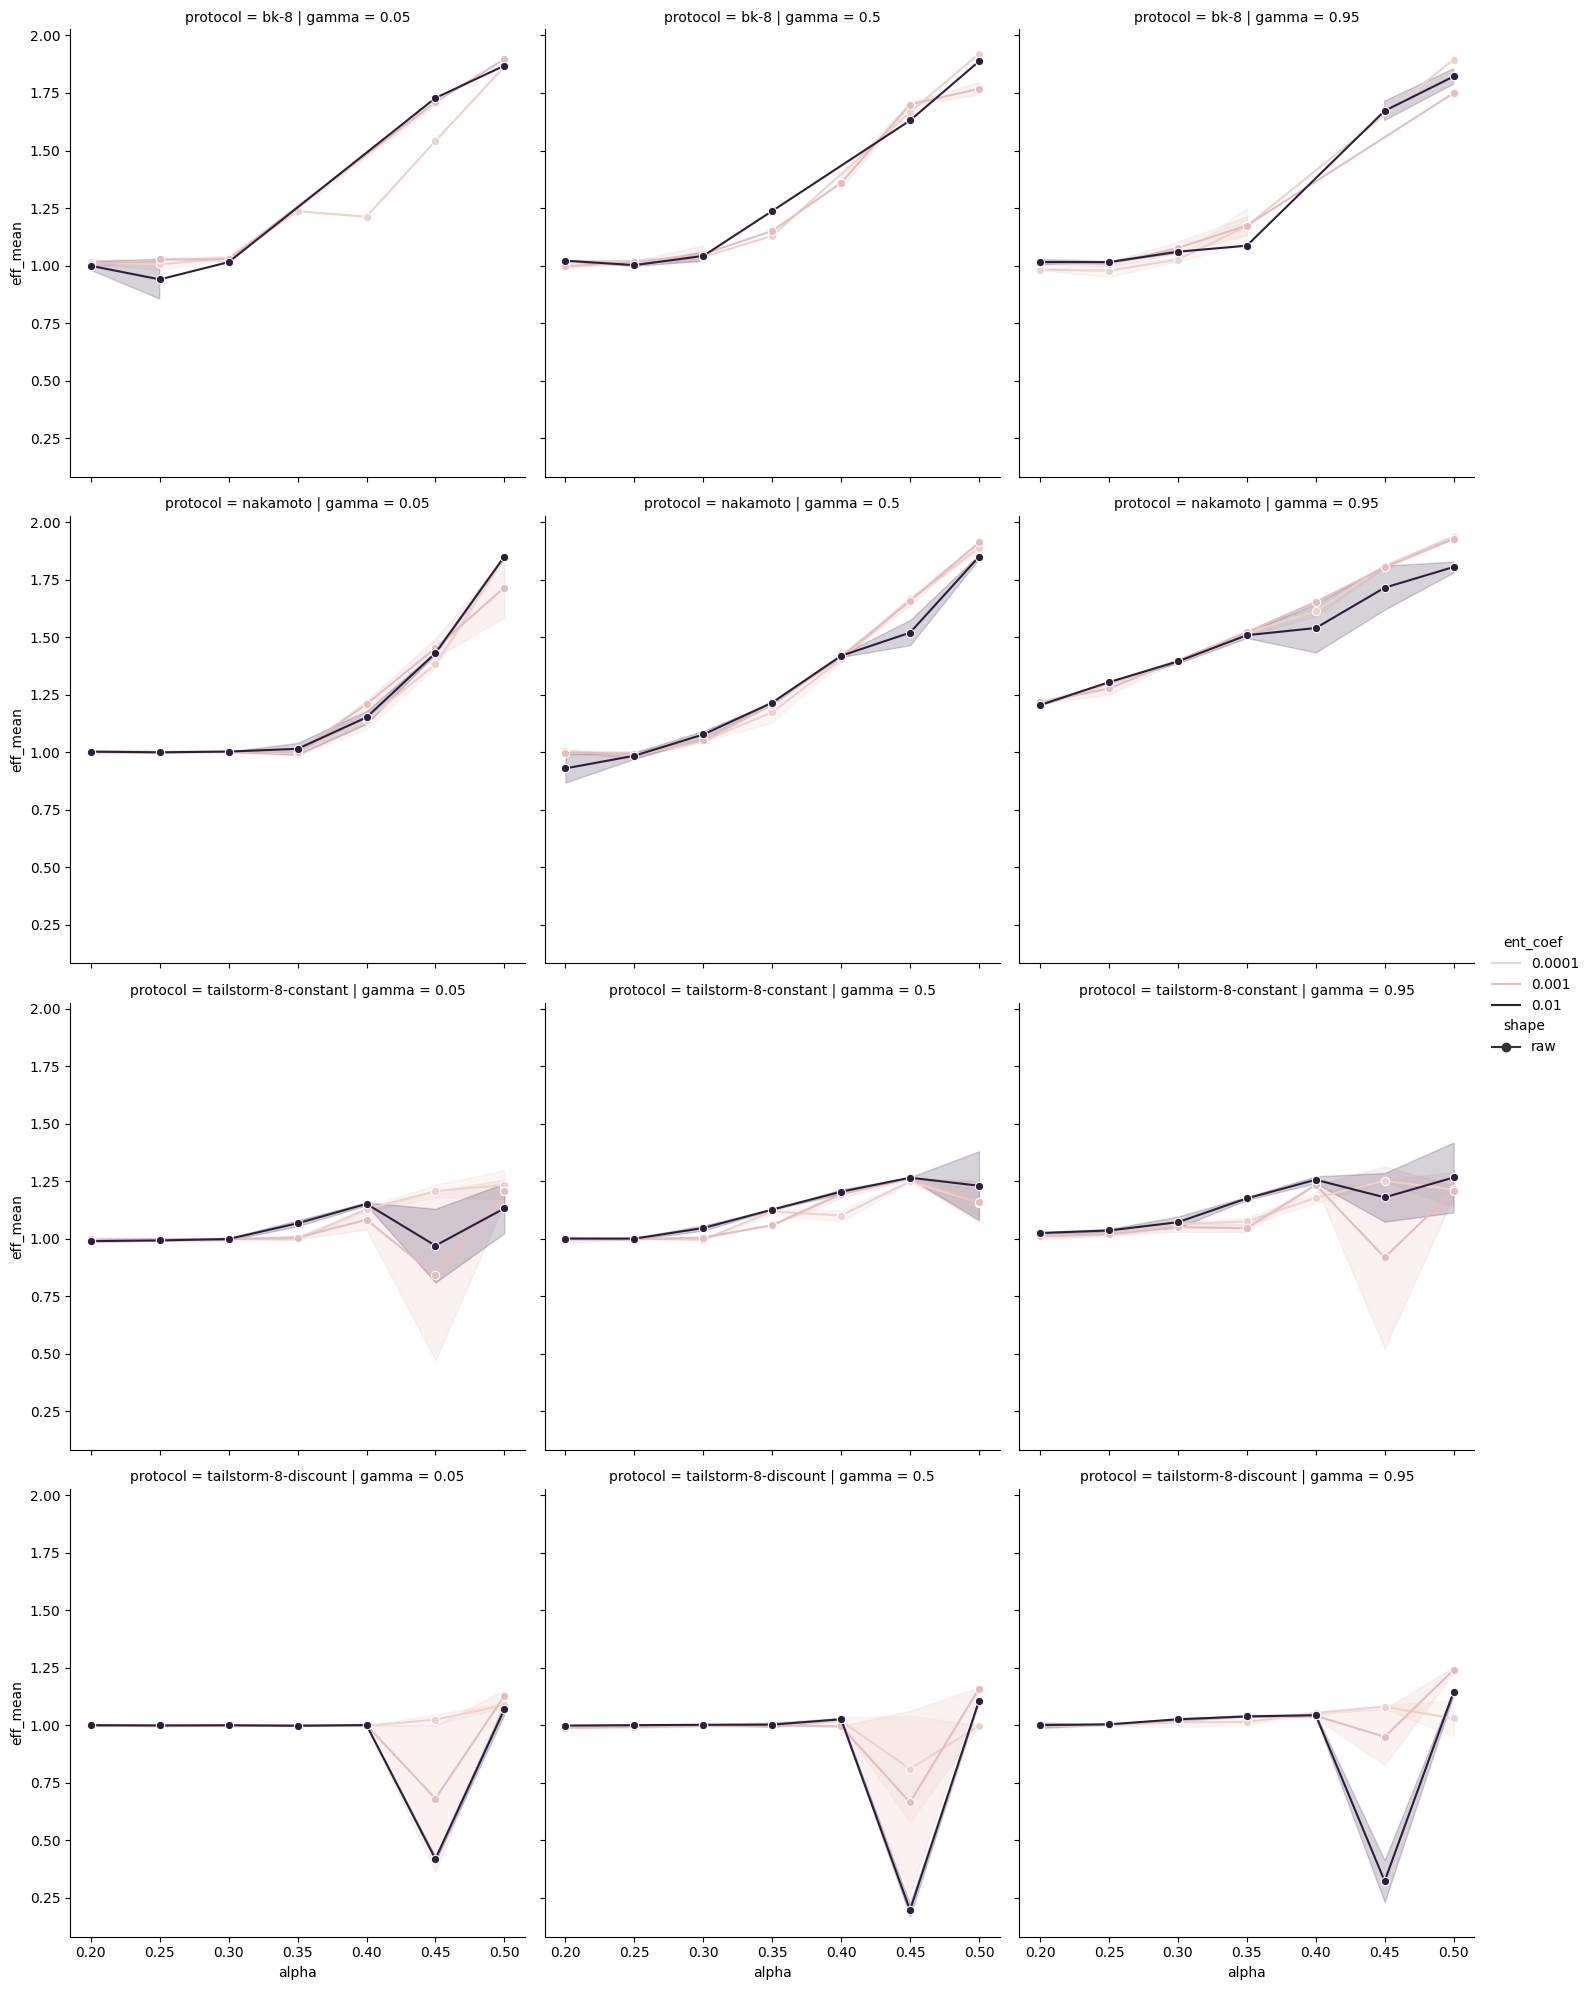

In [14]:
subset = points
fig = sns.relplot(
    kind="line",
    data=subset,
    y="eff_mean",
    x="alpha",
    col="gamma",
    row="protocol",
    hue="ent_coef",
    style="shape",
    markers=True,
)

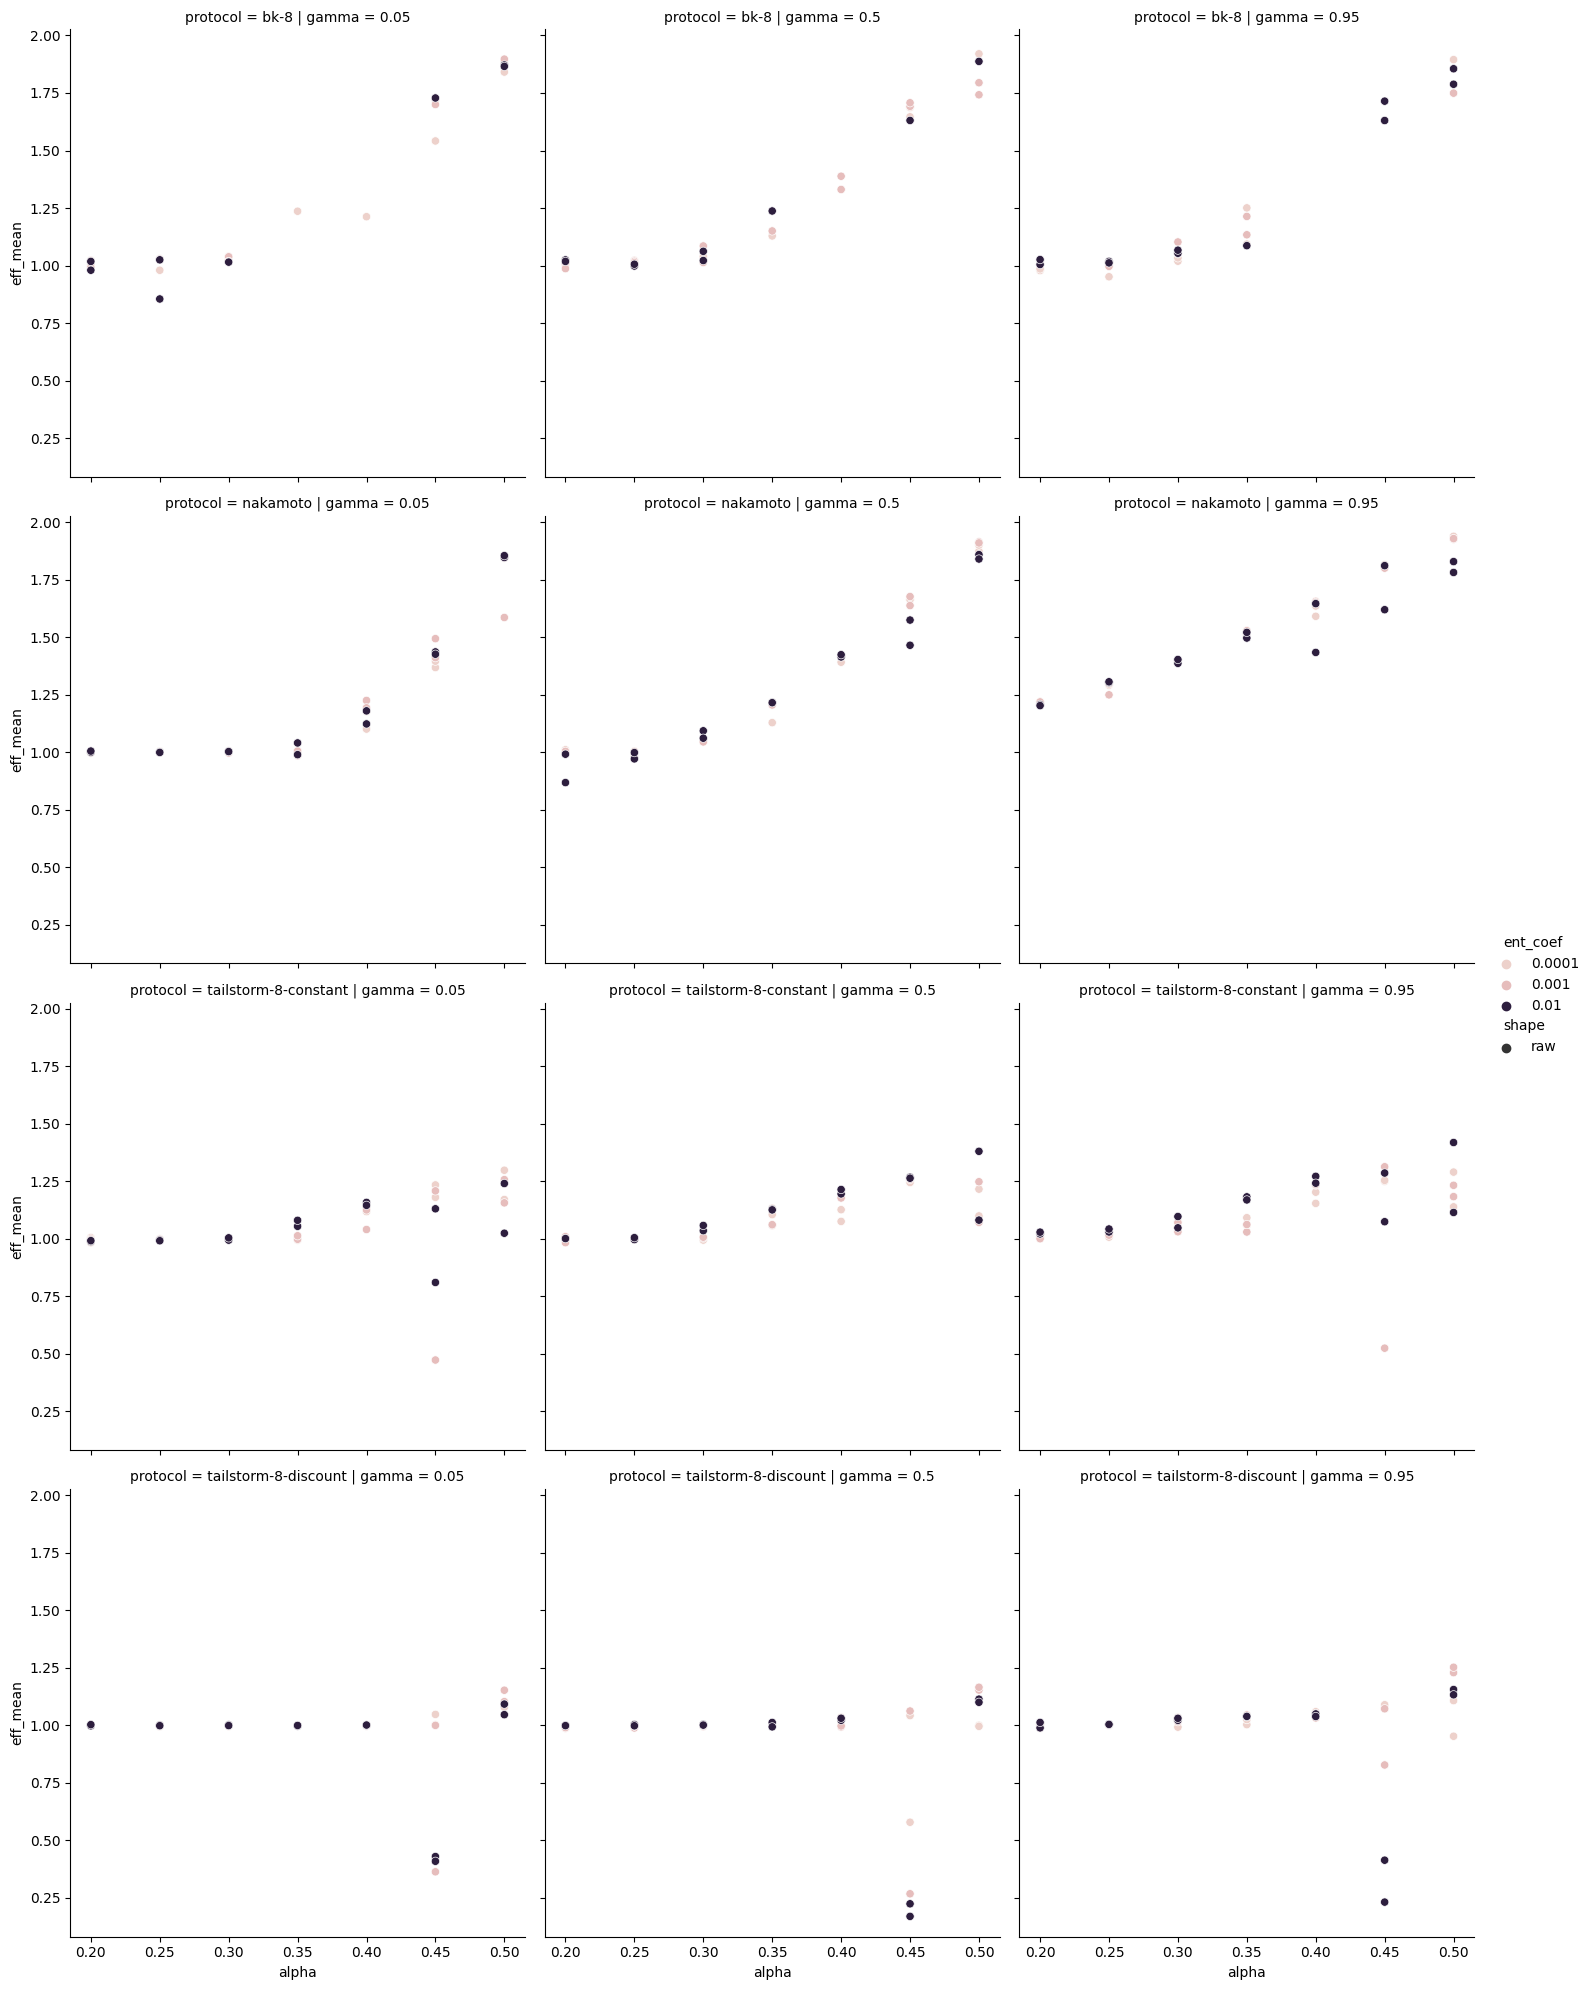

In [16]:
subset = points
fig = sns.relplot(
    data=subset,
    y="eff_mean",
    x="alpha",
    col="gamma",
    row="protocol",
    hue="ent_coef",
    style="shape",
)